# EXP8. 인물사진을 만들어 보자

## Q: 만화캐릭터도 인식이 될까?

오늘 만들어볼 목표는 핸드폰 인물사진 모드입니다. 사실 핸드폰 인물 사진 모드를 정확히 따라 하기 위해서 2개의 렌즈가 필요하지만 딥러닝을 적용해서 하나의 렌즈만으로 비슷하게 흉내 내 보겠습니다.

인물사진 모드에서 사용되는 용어
한국에서는 배경을 흐리게 하는 기술을 주로 '아웃포커싱'이라고 표현합니다. 하지만 아웃포커싱은 한국에서만 사용하는 용어이고 정확한 영어 표현은 얕은 피사계 심도(shallow depth of field) 또는 셸로우 포커스(shallow focus) 라고 합니다.

또한 "보케(bokeh)"라는 일본어에서 유래된 표현 또한 많이 사용합니다. 영문권에서도 많이 사용하는 용어지만 사실 전문적으로 사진을 다루시는 분이 아니라면 그 의미가 직관적으로 다가오기 어렵습니다. 핸드폰 제조사에서도 이것을 알고 '인물사진(portrait)'이라는 직관적인 용어를 잘 만들어 낸 것 같습니다.


##### 학습목표
 - 딥러닝을 적용하여 핸드폰 인물 사진 모드를 따라 해 보자.
 - 만화캐릭터 / 만화에 나온 강아지를 segmentation해보자
 - 크로마키
 - 
 
 
####  프로젝트 전체 개요 다시 정리
인물모드 사진 아웃포커싱 효과 적용되게 하기
사람, 고양이 사진, 크로마키사진 1장 이상 제작
제작한 인물모드 사진에서 문제점 찾기
문제점 지적, 원인 찾기
솔루션 찾기
문제점 개선할 수 있는 솔루션 찾기
추가 depth 정보 활용
semantic segmantation mask의 오류 보완할 수 있는 솔루션 제시


### 8-2. 셸로우 포커스 만들기 (1) 사진을 준비하자
하나의 카메라로 셸로우 포커스(shallow focus)를 만드는 방법

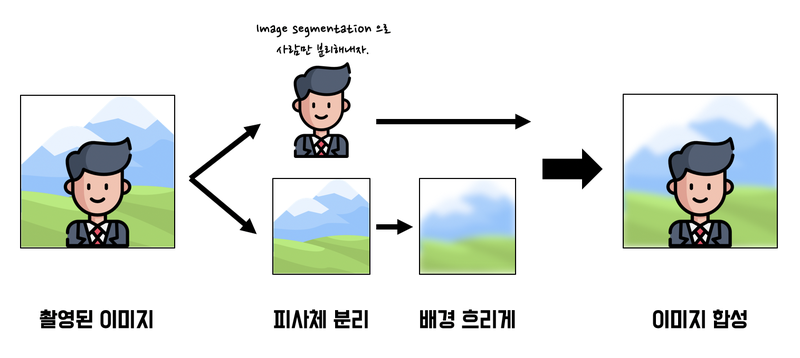


두 개의 렌즈가 맡은 역할을 하나의 렌즈에서 구현해야 합니다. 이미지 세그멘테이션(image segmentation) 기술을 이용하면 하나의 이미지에서 배경과 사람을 분리할 수 있습니다. 분리된 배경을 블러(blur) 처리 후 사람 이미지와 다시 합하면 아웃포커싱 효과를 적용한 인물 사진을 얻을 수 있습니다.

따라서 우리는 다음과 같은 후가공으로 '인물사진 모드'인 사진을 만들 겁니다.

배경이 있는 셀카를 촬영합니다. (배경과 사람의 거리가 약간 멀리 있으면 좋습니다.)
시멘틱 세그멘테이션(Semantic segmentation)으로 피사체(사람)와 배경을 분리합니다.
블러링(blurring) 기술로 배경을 흐리게 합니다.
피사체를 배경의 원래 위치에 합성합니다.

In [1]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf


img_path = os.getenv('HOME')+'/aiffel/EXP_08_human_segmentation/images/my_image.png'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
cat_img_path = os.getenv('HOME')+'/aiffel/EXP_08_human_segmentation/images/mew.png'
ani_img_path = os.getenv('HOME')+'/aiffel/EXP_08_human_segmentation/images/shou_tucker.png'
elon_img_path = os.getenv('HOME')+'/aiffel/EXP_08_human_segmentation/images/musk.png'


img_orig = cv2.imread(img_path) 
cat_img_orig = cv2.imread(cat_img_path)
ani_img_orig = cv2.imread(ani_img_path)
elon_img_orig = cv2.imread(elon_img_path)

print (img_orig.shape)
print (cat_img_orig.shape)
print (ani_img_orig.shape)
print (elon_img_orig.shape)

(1280, 960, 3)
(947, 668, 3)
(444, 315, 3)
(2775, 4251, 3)


In [2]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

preprocess()는 전처리, run()은 실제로 세그멘테이션을 하는 함수입니다. 먼저 input tensor를 만들기 위해 preprocess() 함수에서 이미지를 전처리 합니다.

모델이 받는 입력 크기가 정해져 있으므로 이에 따라 적절한 크기로 resize 하고, OpenCV의 디폴트 BGR 채널 순서를 텐서플로우에 맞는 RGB로 수정합니다.

전처리된 이미지는 run() 함수에서 입력값으로 사용되는 것을 볼 수 있습니다.

##### 편집자 주

AIFFEL의 딥러닝 관련 코드는 Tensorflow V2 기준으로 작성되지만, 이번 노드에서는 구글에서 Tensorflow V1으로 작성한 DeepLab 모델 구조를 그대로 가져와 활용하면서,

Tensorflow V2에서 V1 코드와 모델 구조를 활용할 수 있도록 제공하는 tf.compat.v1를 활용하고 있습니다.

그래서 다소 생소할 수 있는 session, graph, feed_dict 등 Tensorflow V2에서는 Model, Input 등에 감추어져 있는 구조가 위 코드에 드러나 있습니다.

Tensorflow V1에서 작성된 수많은 레거시 코드들을 활용하려면 어떻게 해야 하는지를 학습하는 의미에서 Tensorflow V2 코드와 비교해 가면서 보기를 바랍니다.

In [3]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


(1280, 960, 3) (513, 384, 3) 20
(947, 668, 3) (513, 361, 3) 20
(444, 315, 3) (513, 363, 3) 5
(2775, 4251, 3) (334, 513, 3) 15


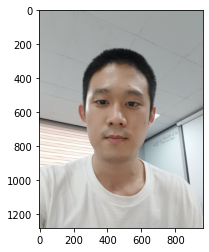

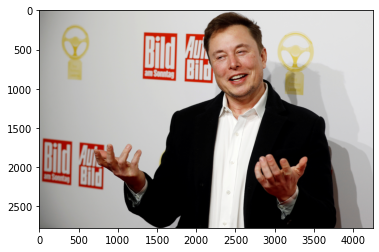

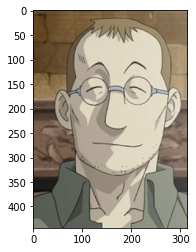

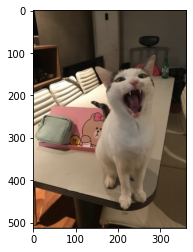

In [4]:
img_resized, seg_map = MODEL.run(img_orig)
cat_img_resized, cat_seg_map = MODEL.run(cat_img_orig)
ani_img_resized, ani_seg_map = MODEL.run(ani_img_orig)
elon_img_resized, elon_seg_map = MODEL.run(elon_img_orig)


cat_img_resized, cat_seg_map = MODEL.run(cat_img_orig)

print (img_orig.shape, img_resized.shape, seg_map.max())
print (cat_img_orig.shape, cat_img_resized.shape, cat_seg_map.max())
print (ani_img_orig.shape, ani_img_resized.shape, ani_seg_map.max())
print (elon_img_orig.shape, elon_img_resized.shape, elon_seg_map.max())

# selfie show
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

# elon musk
plt.imshow(cv2.cvtColor(elon_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

# animation character
plt.imshow(cv2.cvtColor(ani_img_orig, cv2.COLOR_BGR2RGB))
plt.show()

# cat image show
plt.imshow(cv2.cvtColor(cat_img_resized, cv2.COLOR_BGR2RGB))
plt.show()

img_orig 의 크기는 800x450 이고 img_resized 의 크기는 513x288 이 출력됐습니다. 입력 이미지 크기가 달라지면 resize 크기도 조금씩 달라지겠죠? (cv2는 이미지를 HWC(Height, Width, Channel) 순서로 표시한다는 점 잊지 마세요!)

세그멘테이션 맵에서 가장 큰 값(물체로 인식된 라벨 중 가장 큰 값)을 뜻하는 seg_map.max() 는 20 이라는 값이 출력됩니다. 무슨 의미일까요? (사진에 따라서 seg_map.max() 값이 다르게 출력 될 수 있습니다.)

위에서 말씀드린 것처럼 구글이 제공한 DeepLab은 PASCAL VOC의 라벨로 학습되었습니다. 제공하는 라벨 종류는 아래와 같습니다.

In [5]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

background를 제외하면 20개의 클래스가 있습니다. 따라서 20 의 의미는 tv 가 되겠네요! 0부터 시작하니까요.( 제 사진에서는 20이 나왔지만 여러분 사진에 tv가 검출되지 않았다면 다른 숫자가 나올 것입니다.)

우리는 이 중 사람(person) 라벨, 즉 15를 가진 영역만 검출해 내고 싶습니다. 마스크를 만들고 시각화해 볼까요?

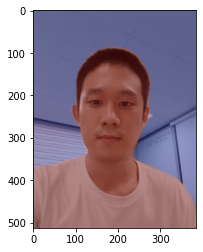

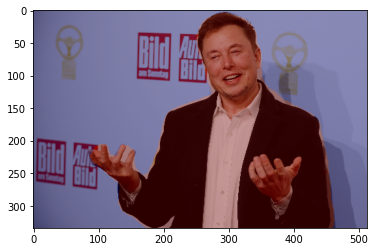

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in long_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in multiply


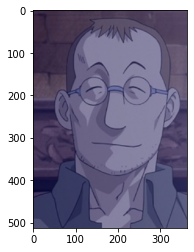

In [6]:
# selfie
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

# elon
elon_img_show = elon_img_resized.copy()
elon_seg_map = np.where(elon_seg_map == 15, 15, 0) # 예측 중 사람만 추출
elon_img_mask = elon_seg_map * (255/elon_seg_map.max()) # 255 normalization
elon_img_mask = elon_img_mask.astype(np.uint8)
elon_color_mask = cv2.applyColorMap(elon_img_mask, cv2.COLORMAP_JET)
elon_img_show = cv2.addWeighted(elon_img_show, 0.6, elon_color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(elon_img_show, cv2.COLOR_BGR2RGB))
plt.show()


# animation character
ani_img_show = ani_img_resized.copy()
ani_seg_map = np.where(ani_seg_map == 15, 15, 0) # 예측 중 사람만 추출
ani_img_mask = ani_seg_map * (255/ani_seg_map.max()) # 255 normalization
ani_img_mask = ani_img_mask.astype(np.uint8)
ani_color_mask = cv2.applyColorMap(ani_img_mask, cv2.COLORMAP_JET)
ani_img_show = cv2.addWeighted(ani_img_show, 0.6, ani_color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(ani_img_show, cv2.COLOR_BGR2RGB))
plt.show()



사람을 뜻하는 15 외 예측은 0으로 만들었습니다. 그럼 예측된 세그멘테이션 이미지(map)는 최댓값이 15가 됩니다. 일반 이미지는 0부터 255 까지의 값을 사용해 픽셀을 표현하므로, 세그멘테이션 맵에 표현된 값을 원본 이미지에 그림 형태로 출력하기 위해 255로 정규화 합니다. applyColorMap() 함수로 색을 적용하고 이미지를 화면에 출력합니다.

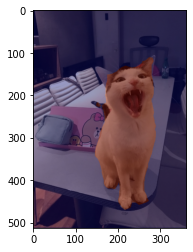

In [7]:
# cat image segmentation
cat_img_show = cat_img_resized.copy()
cat_seg_map = np.where(cat_seg_map == 8, 8, 0) # 예측 중 cat(8)만 추출
cat_img_mask = cat_seg_map * (255/cat_seg_map.max()) # 255 normalization
cat_img_mask = cat_img_mask.astype(np.uint8)
cat_color_mask = cv2.applyColorMap(cat_img_mask, cv2.COLORMAP_JET)
cat_img_show = cv2.addWeighted(cat_img_show, 0.6, cat_color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(cat_img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 8-5. 셸로우 포커스 만들기 (4) 세그멘테이션 결과를 원래 크기로 복원하기

DeepLab 모델을 사용하기 위해 이미지 크기를 작게 resize 해서 입력했습니다. 따라서 출력도 resize 된 입력 크기와 같게 나오게 됩니다.

세그멘테이션 결과(mask)를 원래 크기로 복원해 보겠습니다.

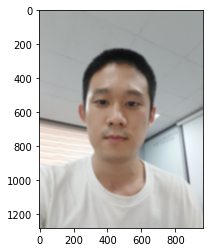

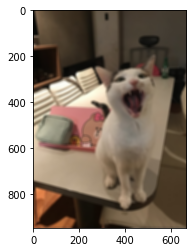

In [8]:
# selfie blur
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()


# selfie chormakey (ToDo)


# animation character blur

# cat blur
cat_img_orig_blur = cv2.blur(cat_img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(cat_img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

cv2.resize() 함수를 이용합니다. 크기를 키울 때 보간(interpolation) 을 고려해야 하는데요, cv2.INTER_NEAREST를 이용해서 깔끔하게 처리할 수 있지만 더 정확히 확대하기 위해 cv2.INTER_LINEAR 를 사용합니다. 여기서 보간법(interpolation)은 이미지의 크기를 변경(scaling)하는 과정에서 컴퓨터가 사이사이 픽셀값을 채우는 방법입니다. 자세한 사항은 opencv-python 문서를 참고할 수 있습니다.

결과적으로 img_mask_up 은 경계가 블러된 픽셀값 0~255의 이미지를 얻습니다. 확실한 경계를 다시 정하기 위해 중간값인 128을 기준으로 임계값(threshold)을 설정합니다. 128 이하의 값은 0으로 128 이상의 값은 255로 만드는 방법입니다.

### 8-5. 셸로우 포커스 만들기 (4) 세그멘테이션 결과를 원래 크기로 복원하기

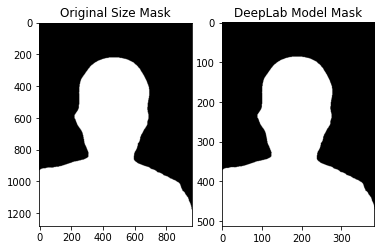

Text(0.5, 1.0, 'Cat DeepLab Model Mask')

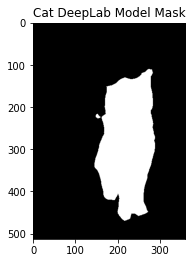

In [9]:
# Selfie blur
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()



# Selfie Chroma key (ToDo)






# cat image
cat_img_mask_up = cv2.resize(cat_img_mask, cat_img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, cat_img_mask_up = cv2.threshold(cat_img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,2)
plt.imshow(cat_img_mask, cmap=plt.cm.binary_r)
ax.set_title('Cat DeepLab Model Mask')

### 8-6. 셸로우 포커스 만들기 (5) 배경 흐리게 하기

이번에는 배경을 흐리게 만듭니다. blur()함수를 이용합니다.

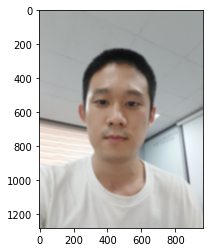

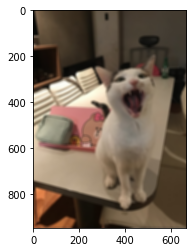

In [10]:
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()



plt.imshow(cv2.cvtColor(cat_img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출하겠습니다.

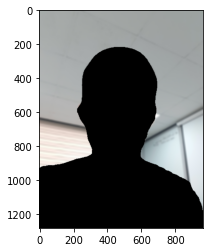

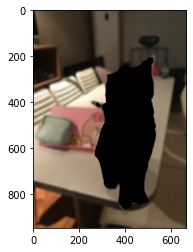

In [11]:
# selfie blur
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()


# selfie chromakey


# cat blur
cat_img_mask_color = cv2.cvtColor(cat_img_mask_up, cv2.COLOR_GRAY2BGR)
cat_img_bg_mask = cv2.bitwise_not(cat_img_mask_color)
cat_img_bg_blur = cv2.bitwise_and(cat_img_orig_blur, cat_img_bg_mask)
plt.imshow(cv2.cvtColor(cat_img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

bitwise_not 함수를 이용하면 이미지가 반전됩니다. 배경은 255 사람은 0이 되겠죠? 반전된 세그멘테이션 결과를 이용해서 이미지와 bitwise_and 연산을 수행하면 배경만 있는 영상을 얻을 수 있습니다.

StackOverflow: bitwise_not, bitwise_and 함수를 사용해 이미지 바꾸기 [https://stackoverflow.com/questions/32774956/explain-arguments-meaning-in-res-cv2-bitwise-andimg-img-mask-mask]

### 8-7. 셸로우 포커스 만들기 (6) 흐린 배경과 원본 영상 합성

이제 배경 영상과 사람 영상을 합치기만 하면 되겠죠?

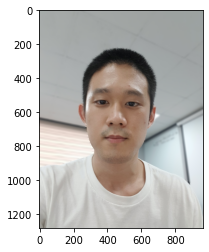

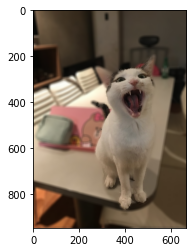

In [12]:
# selfie blur
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()


# selfie chromakey


# cat blur
cat_img_concat = np.where(cat_img_mask_color==255, cat_img_orig, cat_img_bg_blur)
plt.imshow(cv2.cvtColor(cat_img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## Chroma Key

(947, 668, 3) (513, 361, 3) 20


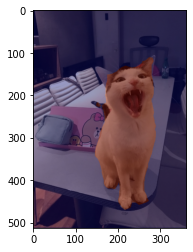

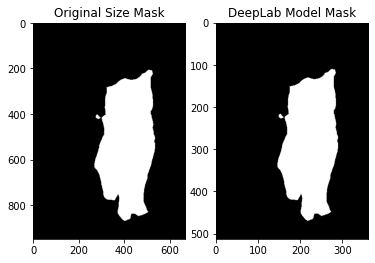

(668, 947, 3)
변경하려는 사이즈:  (668, 947)
배경 변경한 사이즈:  (947, 668, 3)


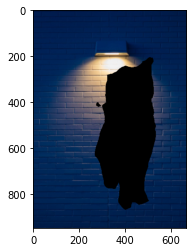

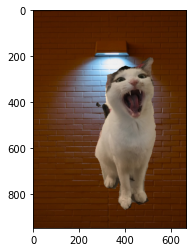

In [18]:
img_dir = os.getenv('HOME')+'/aiffel/EXP_08_human_segmentation/images'


def bg_concat(img_name, label, bg_name):
    img_path = os.path.join(img_dir, img_name)
    img_orig = cv2.imread(img_path)
    
    # 이미지를 네트워크에 입력
    img_resized, seg_map = MODEL.run(img_orig)
    print (img_orig.shape, img_resized.shape, seg_map.max())
    
    # 마스크 만들기
    img_show = img_resized.copy()
    seg_map = np.where(seg_map == LABEL_NAMES.index(label), LABEL_NAMES.index(label), 0)
    img_mask = seg_map * (255/seg_map.max())
    img_mask = img_mask.astype(np.uint8)
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)
    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()
    
    # 세그멘테이션 결과(mask)를 원래 크기로 복원
    img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

    ax = plt.subplot(1,2,1)
    plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
    ax.set_title('Original Size Mask')

    ax = plt.subplot(1,2,2)
    plt.imshow(img_mask, cmap=plt.cm.binary_r)
    ax.set_title('DeepLab Model Mask')
    plt.show()
    
    # 배경 이미지 불러오기
    bg_path = os.path.join(img_dir, bg_name)
    img_bg = cv2.imread(bg_path)
    
    img_bg = MODEL.preprocess(img_bg)
    img_bg = cv2.resize(img_bg,img_mask_up.shape)
    print(img_bg.shape)
    plt.imshow(img_bg)
    
    target_size = (img_orig.shape[1], img_orig.shape[0])
    print("변경하려는 사이즈: ", target_size)
    bg_resize = cv2.resize(img_bg, target_size)
    print("배경 변경한 사이즈: ", bg_resize.shape)
    
    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_masked = cv2.bitwise_and(bg_resize, img_bg_mask)
    plt.imshow(img_bg_masked)
    plt.show()
    
    img_concat = np.where(img_mask_color==255, img_orig, bg_resize)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()
    
    
bg_concat('mew.png','cat','background.png')

세그멘테이션 마스크가 255인 부분만 원본 영상을 가지고 오고 반대인 영역은 블러된 미지 값을 사용합니다. (오 대박 ㄷㄷㄷ 바로 됐다)

## 문제점



#### Cat image segmentation
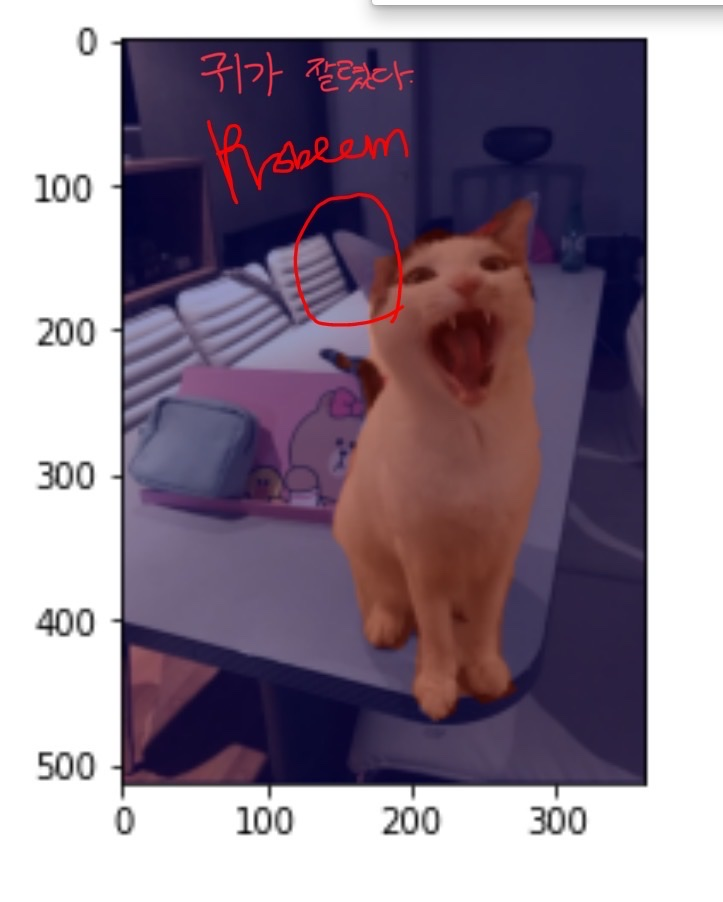


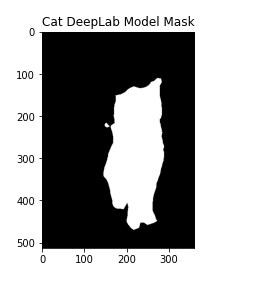

우리집 양양이의 귀가 잘렸다...ㅠㅠ